# Comparison of minimization routines in Cython and Matlab

This serves as a testing platform to learn how to implement the GSL minimization routine in Cython. As Economists tend to use Matlab as a default platform this will form the benchmark. 

The exercise through which we will learn how to use the GSL algorithms implements through a Monte-Carlo simulation the asymptotic convergence of the Bernoulli distribution to the Normal distribution. This will be a one-dimensional minimization routine. 

A single observation drawn from the Bernoulli distribtuion has the following pdf when $y\in{0,1}$:

\begin{equation*}
f_{Y}(y;p_{0}) = p_{0}^{y}\cdot(1-p_{0})^{1-y}
\end{equation*}

We will suppose we have an i.i.d. sample of observations of y, so we can take the joint pdf of the y samples as:

\begin{align*}
f_{Y}(y_{1},...,y_{n};p_{0}) &= \prod_{i=1}^{n}p_{0}^{y_{i}}\cdot(1-p_{0})^{1-y_{i}}\\
&=p_{0}^{\sum_{i=1}^{n}y_{i}}\cdot(1-p_{0})^{\sum_{i=1}^{n}1-y_{i}}
\end{align*}

Applying logs to the above equation gives us the log-likelihood function:

\begin{equation*}
\mathcal{L}(p_{0};y_1...y_n) = \log f\left(y_1,...,y_n; p_{0}\right)=\sum_{i=1}^{n}y_{i}\log(p_{0})+(1-y_{i})\log(1-p_{0})
\end{equation*}

We will set up a Monte-Carlo by using the population probability of $p_{0}=0.2$ to generate a vector y, that we will then use as our observed variable. For each sample size we will run 1000 simulations.

The maximum likelihood estimator of $\widehat{p}$ is $\bar{y}$, the average of the observed incidences of success. Despite this we will maximize the likelihood function to test the speed comparisons and learn to use GSL in Cython. Since we will have to run many minimization routines on different sample sizes we will write an external function that estimates the probability through maximization. We know that $p\in[0,1]$. Although we don't have to it would likely be best if we were to conduct a constrained optimization with the upper and lower bounds as the probability space indicated.

 ## Matlab
 
 Load matlab magic and set up parallel (optionally remove parallel implementation for a setial comparison).

In [1]:
%load_ext pymatbridge

/usr/local/lib/python3.6/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-de6abe02-fa75-459b-91a2-bd7defb63c67
Send 'exit' command to kill the server
.......MATLAB started and connected!


In [2]:
%%matlab
clear all; clc; parpool

Starting parallel pool (parpool) using the 'local' profile ... connected to 4 workers.

ans = 

 Pool with properties: 

            Connected: true
           NumWorkers: 4
              Cluster: local
        AttachedFiles: {}
          IdleTimeout: 30 minute(s) (30 minutes remaining)
          SpmdEnabled: true



In [3]:
%%matlab

%We are asked for sample sizes N=5,50,500. Let's create a
%vector of these samples sizes (I did this with an extra
%sample size to get nicer graph outputs).

N=[5;50;500;5000];

%population probability
p_true = 0.2;

%Simulation run
T=1000;

%Initialize the vectors for the output of the Monte Carlo
%We will initialize a vector of 1000x4, since we have 4
%sample sizes, that is the size of the N vector we created
%is 4x1.
p_hat = NaN(T,size(N,1));

%A starting value of guess for the p_hat that we will find
p_0 = rand;

%Our options for the maximization routine:

options_2 = optimoptions('fmincon','Algorithm','interior-point',...
                         'Display','off','UseParallel',true);

In [5]:
%%matlab

%Program the Monte-Carlo experiment

%outer loop runs the sample sizes
tic
for i=1:size(N,1)

    sample_size = N(i);
    
    %run inner loop = MC loop - to make this go fast 
    %we will need to parallelize this otherwise it will
    %take forever
    
    parfor j=1:T
    
        %First we generate a random sample of points
        %between 0 and 1. We use the rand function 
        %to do this
        
        Y_raw = rand(sample_size,1);
        
        %Now we need to create the Y vector such that it
        %takes the value 1 if the probability is less than
        %or equal to 0.2, and 0 otherwise.
        
        Y = (Y_raw <= p_true);
        
        %Now we can run the fminunc routine on the sample Y 
        %and find the p that maximizes the likelihood of 
        %observing our sample vector Y:
        
        p_hat(j,i) = fmincon(@(p) Bernoulli(p,sample_size,Y),...
                             p_0,[],[],[],[],0,1,[],options_2)
    
    end

end
toc

Elapsed time is 21.678903 seconds.


In [6]:
%%matlab

p_mean = mean(p_hat)
p_SE = std(p_hat)
p_centered = (sqrt(diag(N))*(p_hat - p_true)')';
var_p_true = p_true - p_true^2
E_p_centered = mean(p_centered)
var_p_centered = var(p_centered)


p_mean =

    0.1970    0.1990    0.2000    0.2000


p_SE =

    0.1770    0.0579    0.0178    0.0058


var_p_true =

    0.1600


E_p_centered =

   -0.0067   -0.0068    0.0002    0.0015


var_p_centered =

    0.1567    0.1675    0.1588    0.1664



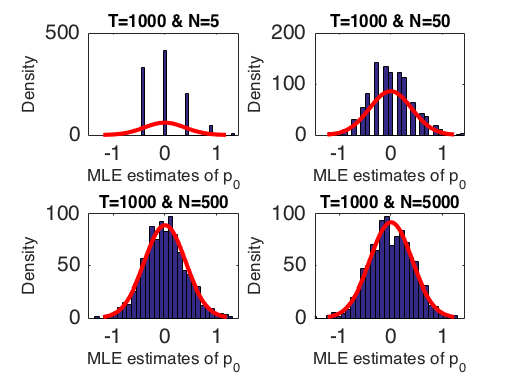

In [7]:
%%matlab

%Generate the histogram of the monte-carlo exercise with a 
%normal distribution super-imposed to see how the sample
%sizes are in relation to the normal. We will create
%subplots.

%First, let's set the bins (how the data is grouped)
bins=30;

%Second, let's find the global minimum and the maximum across 
%all the sameple sizes to set the same axis across all 
%the subplots beta_sim_1 to more easily compare how the dispersion
%(shape of the bell curve) of the estimates change as N changes. 
%Since we have two dimensions we should use nested min and max 
%statements to get the global value.

x_axis_min = min(min(p_centered));
x_axis_max = max(max(p_centered));

%Finally, we run through a loop across the columns of p_centered
%to generate a plot of the distribution of each column (so there 
%will be 4 subplots).

for i=1:size(N,1)

    subplot(2,2,i);
    histfit(p_centered(:,i),bins)
    title(['T=1000 & N=' num2str(N(i))], 'FontSize',8)
    xlabel('MLE estimates of p_0','FontSize',8)
    ylabel('Density', 'FontSize',8)
    xlim([x_axis_min x_axis_max])
    
end

In [9]:
%%matlab
delete(gcp('nocreate'))

Parallel pool using the 'local' profile is shutting down.


## Cython/Python

Here we will program the above cells in Python and call a Monte-Carlo function to yield us the outputs we desire. The Monte-Carlo function will be written in Cython and we will use the %timeit cell magic to give us a run-time of our Cython function. 

In [10]:
import numpy as np

In [27]:
#First we will recreate the first cell in the matlab example in python

#Sample Sizes
N = np.array([5,50,500,5000], dtype='i').reshape((1,4))

#Parameters for MC
T = 1000
p_true = 0.2

#Array of the outputs from the MC
p_hat = np.empty((N.size,T), dtype='f')
p_hat.fill(np.nan)

### Cython Function

In [29]:
%load_ext cython

In [51]:
%%cython

#Global Cython compiler directives
#!python
#cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True

#Import modules: 

from cython.parallel import prange, parallel
from libc.stdlib cimport rand, RAND_MAX, calloc, free, abort
from libc.math cimport log

#Use the CythonGSL package to get the low-level routines
# from cython_gsl cimport *

################ Support Functions for Monte-Carlo Function ##################

cdef void Y_fill(double* Y, double p_true, Py_ssize_t sample_size) nogil:
    
    cdef:
        Py_ssize_t i
        double y
    
    for i in range(sample_size):
        y = rand()/<double>RAND_MAX
        if y <= p_true:
            Y[i] = 1 
            
cdef double LLF(double p, double* param) nogil:
    
    cdef Py_ssize_t i
    
    

########################## Monte-Carlo Function ##############################

cpdef void Monte_Carlo(int[::1] Samples, double[:,::1] p_hat, 
                  Py_ssize_t Sims, double p_true) nogil:
    
    cdef:
        #iterators
        Py_ssize_t i, j
        
        #Variables
        Py_ssize_t sample_size, N=Samples.shape[1]
        
        #Array for Y data
        double* Y
        
        #Arrays for GSL objects
        
    for i in range(N):

        sample_size = Samples[i]

        with parallel(num_threads=8):

            try: 

                #allocate thread-local buffer: memory of the Y variable
                Y = <double*> calloc(sample_size, sizeof(double))
                if Y==NULL: abort()

                for j in prange(Sims, schedule='dynamic'):

                    #fill in the Y array
                    Y_fill(Y,p_true,sample_size)

                    

            finally:
                free(Y)